In [ ]:
#Create your own
# https://www.makesense.ai/

In [28]:
# @title ##**Install mediapipe** { display-mode: "form" }

%cd /content/
from IPython.display import clear_output
!git clone https://github.com/android-iceland/Squid-Game-Mask.git
!pip install mediapipe
!wget https://media.wired.com/photos/5ed6891ed9fb171733fd7840/master/pass/Ideas-Zuckerberg-1200875675.jpgimport os
os.rename("/content/Squid-Game-Mask/Ideas-Zuckerberg-1200875675.jpg","image.jpg")
clear_output()


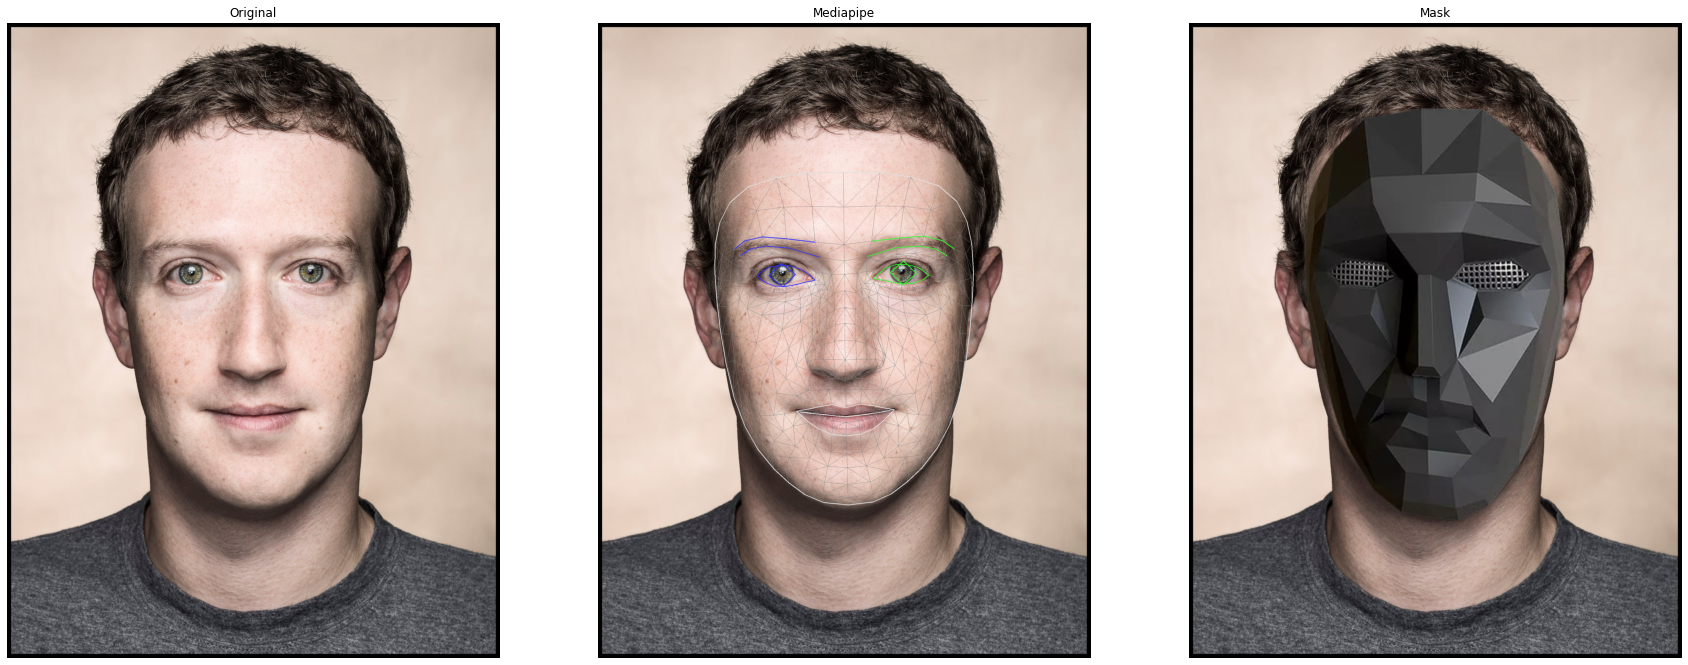

In [44]:
# @title ##**Fill this form** { display-mode: "form" }

%cd /content/Squid-Game-Mask
clear_output()
import cv2
import mediapipe as mp
from google.colab.patches import cv2_imshow
import csv
import numpy as np

iamge_path = '/content/image.jpg'  #@param {type: "string"}



mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_face_mesh = mp.solutions.face_mesh
drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1)
face_mesh= mp_face_mesh.FaceMesh(
    max_num_faces=1,
    refine_landmarks=True,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5)


def face_point(image,drawing=False):
  img=image.copy()
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  results = face_mesh.process(image)
  faces=[]
  if results.multi_face_landmarks:
    for faceLms in results.multi_face_landmarks:
      face = []
      for id,lm in enumerate(faceLms.landmark):
          ih, iw, ic = image.shape
          x,y = int(lm.x*iw), int(lm.y*ih)
          face.append([id,x,y])     
      faces.append(face)
  
  if results.multi_face_landmarks:
    if drawing:
      for face_landmarks in results.multi_face_landmarks:
        mp_drawing.draw_landmarks(
            image=image,
            landmark_list=face_landmarks,
            connections=mp_face_mesh.FACEMESH_TESSELATION,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp_drawing_styles
            .get_default_face_mesh_tesselation_style())
        mp_drawing.draw_landmarks(
            image=image,
            landmark_list=face_landmarks,
            connections=mp_face_mesh.FACEMESH_CONTOURS,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp_drawing_styles
            .get_default_face_mesh_contours_style())
        mp_drawing.draw_landmarks(
            image=image,
            landmark_list=face_landmarks,
            connections=mp_face_mesh.FACEMESH_IRISES,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp_drawing_styles
            .get_default_face_mesh_iris_connections_style())   
  image=cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
  return image,faces

def mask_overlay(image, faces,mask_img,mask_points):
    mirror_point = {
        234: 1,
        93: 2,
        132: 3,
        58: 4,
        172: 5,
        136: 6,
        150: 7,
        149: 8,
        176: 9,
        148: 10,
        152: 11,
        377: 12,
        400: 13,
        378: 14,
        379: 15,
        365: 16,
        397: 17,
        288: 18,
        361: 19,
        323: 20,
        454: 21,
        356: 22,
        389: 23,
        251: 24,
        284: 25,
        332: 26,
        297: 27,
        338: 28,
        10: 29,
        109: 30,
        67: 31,
        103: 32,
        54: 33,
        21: 34,
        162: 35,
        127: 36,
    }

    src_pts = []
    for i in sorted(mask_points.keys()):
        try:
            src_pts.append(np.array(mask_points[i]))
        except ValueError:
            continue
    src_pts = np.array(src_pts, dtype="float32")
    extend_y = [
        1,
        2,
        3,
        4,
        5,
        6,
        7,
        8,
        9,
        10,
        11,
        12,
        13,
        14,
        15,
        16,
        17,
        18,
        19,
        20,
        21,
    ]
    extend_y=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21]
    minimize_y = [22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]
    face_points = {}
    mask_up = 180 #@param {type: "slider", min: 0, max: 200}
    mask_down = 17 #@param {type: "slider", min: 0, max: 100}
    for i in faces[0]:
        for j in mirror_point.keys():
            if i[0] == j:
                if mirror_point[i[0]] in minimize_y:
                    face_points[mirror_point[j]] = [float(i[1]), float(i[2] - mask_up)]
                else:
                    if mirror_point[i[0]] in extend_y:
                        face_points[mirror_point[j]] = [float(i[1]), float(i[2] + mask_down)]
                    else:
                        face_points[mirror_point[j]] = [float(i[1]), float(i[2])]

    dst_pts = []
    for i in sorted(face_points.keys()):
        try:
            dst_pts.append(np.array(face_points[i]))
        except ValueError:
            continue
    dst_pts = np.array(dst_pts, dtype="float32")
    M, _ = cv2.findHomography(src_pts, dst_pts)
    # transformed masked image
    transformed_mask = cv2.warpPerspective(
        mask_img,
        M,
        (image.shape[1], image.shape[0]),
        None,
        cv2.INTER_LINEAR,
        cv2.BORDER_CONSTANT,
        borderValue=[0, 0, 0, 0],
    )
    png_image = normalize8(transformed_mask)
    new_image = overlay_transparent(image, png_image, 0, 0)
    return image

def normalize8(I):
    mn = I.min()
    mx = I.max()
    mx -= mn
    I = ((I - mn) / mx) * 255
    return I.astype(np.uint8)



def overlay_transparent(background, overlay, x, y):

    background_width = background.shape[1]
    background_height = background.shape[0]

    if x >= background_width or y >= background_height:
        return background

    h, w = overlay.shape[0], overlay.shape[1]

    if x + w > background_width:
        w = background_width - x
        overlay = overlay[:, :w]

    if y + h > background_height:
        h = background_height - y
        overlay = overlay[:h]

    if overlay.shape[2] < 4:
        overlay = np.concatenate(
            [
                overlay,
                np.ones((overlay.shape[0], overlay.shape[1], 1), dtype=overlay.dtype)
                * 255,
            ],
            axis=2,
        )

    overlay_image = overlay[..., :3]
    mask = overlay[..., 3:] / 255.0

    background[y : y + h, x : x + w] = (1.0 - mask) * background[
        y : y + h, x : x + w
    ] + mask * overlay_image

    return background

select_mask  ="Villain Mask"  #@param ["Villain Mask", "Circle Mask"]
if select_mask == "Villain Mask":
  mask_path = "./assets/villain_mask.png"
  csv_path = "./assets/villain_mask.csv"
if select_mask == "Circle Mask":
  mask_path = "./assets/circle_mask.png"
  csv_path = "./assets/circle_mask.csv"
mask_img = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
mask_img = mask_img.astype(np.float32)
mask_img = mask_img / 255.0
mask_annotation = csv_path
mask_points = {}
with open(mask_annotation) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=",")
    for i, row in enumerate(csv_reader):
        mask_points[int(row[0])] = [float(row[1]), float(row[2])]


image=cv2.imread(iamge_path)
image=cv2.flip(image, 1)
Image1=image.copy()
img,faces=face_point(image,drawing=True)
Image2=img.copy()
if len(faces)>=1:
  mask_image=mask_overlay(image,faces,mask_img,mask_points)
  Image3=mask_image.copy()


import cv2
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(30, 15))
rows = 1
columns = 3
fig.add_subplot(rows, columns, 1)

# showing image
plt.imshow(cv2.cvtColor(Image1, cv2.COLOR_RGB2BGR))
plt.axis('off')
plt.title("Original")

# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)

# showing image
plt.imshow(cv2.cvtColor(Image2, cv2.COLOR_RGB2BGR))
plt.axis('off')
plt.title("Mediapipe")

# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)

# showing image
plt.imshow(cv2.cvtColor(Image3, cv2.COLOR_RGB2BGR))
plt.axis('off')
plt.title("Mask")

plt.show()
